# Sequential alignment

In this example we show how to use sequential policy and {func}`~moscot.problems.space.AlignmentProblem.align` to produce a sequential alignment of spatial samples.

:::{seealso}
- See {doc}`400_subset_policy.ipynb` on how to use different policies.
- See {doc}`../tutorials/300_spatial_alignment.ipynb` on how to align spatial transcriptomics data.
:::

## Preliminaries

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)


from moscot import datasets
from moscot.problems.space import AlignmentProblem

import squidpy as sq

Simulate data using {func}`~moscot.datasets.sim_align`.

In [2]:
adata = datasets.sim_align()
adata

AnnData object with n_obs × n_vars = 1200 × 500
    obs: 'batch'
    uns: 'batch_colors'
    obsm: 'spatial'

The `adata` consits of 3 different slides (batches), each having 400 cells.

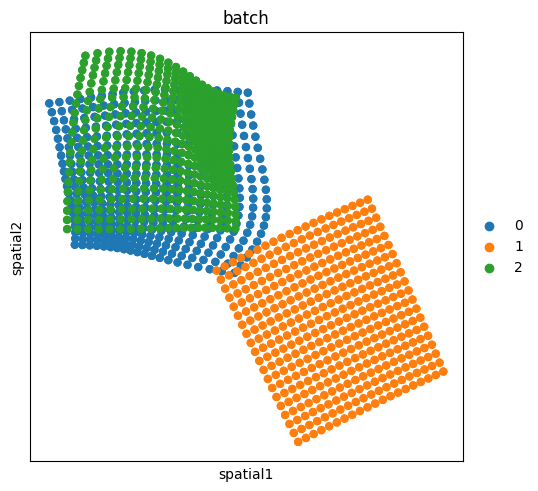

In [3]:
sq.pl.spatial_scatter(adata, shape=None, library_id="batch", color="batch")

In [4]:
ap = AlignmentProblem(adata=adata)
ap = ap.prepare(batch_key="batch", policy="sequential")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   


In [5]:
ap = ap.solve()
ap.solutions

INFO     Solving `2` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            


{('1', '2'): OTTOutput[shape=(400, 400), cost=1.1172, converged=True],
 ('0', '1'): OTTOutput[shape=(400, 400), cost=1.0933, converged=True]}

##Aligning the slides

When we use {func}`~moscot.problems.space.AlignmentProblem.align` as is, all of the slides are aligned to the reference:

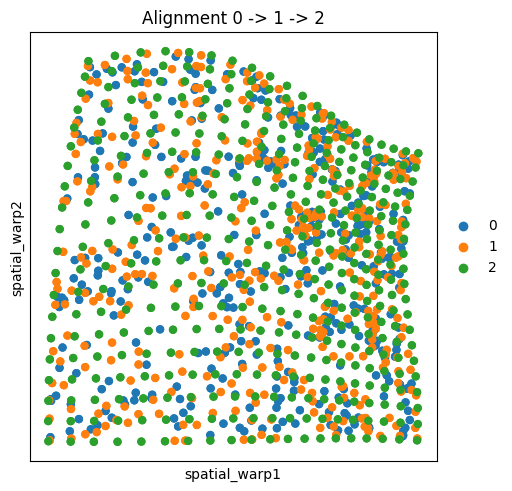

In [6]:
ap.align(reference="2", key_added="spatial_warp")
sq.pl.spatial_scatter(
    adata,
    shape=None,
    spatial_key="spatial_warp",
    library_id="batch",
    color="batch",
    title="Alignment 0 -> 1 -> 2",
)

As, according to the sequential policy, no transport map was computed from batch 0 to batch 2 directly, the alignment 0 -> 2 is achieved by chaining two transport maps 0 -> 1 -> 2.

Now, if we want to see the mapping of only the directly sequential batches, there are two options.

First, we can use {func}`~moscot.problems.space.AlignmentProblem.align` multiple times, changing the reference batch and subsetting adata for plotting if needed.

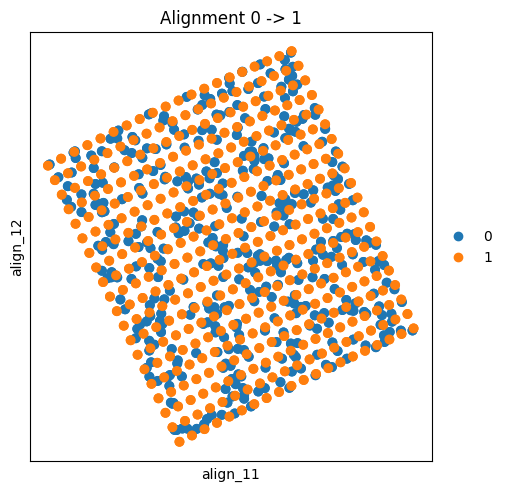

In [7]:
ap.align(reference="1", key_added="align_1")
sq.pl.spatial_scatter(
    adata[adata.obs["batch"].isin(("0", "1"))],
    shape=None,
    spatial_key="align_1",
    library_id="batch",
    color="batch",
    title="Alignment 0 -> 1",
)

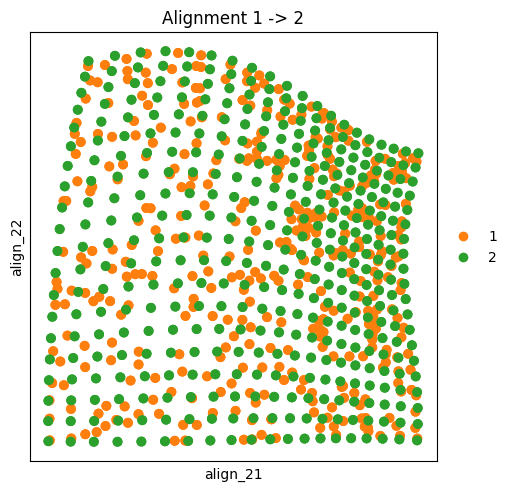

In [8]:
ap.align(reference="2", key_added="align_2")
sq.pl.spatial_scatter(
    adata[adata.obs["batch"].isin(("1", "2"))],
    shape=None,
    spatial_key="align_2",
    library_id="batch",
    color="batch",
    title="Alignment 1 -> 2",
)

The second option would be instantiating different {class}`~moscot.problems.space.AlignmentProblem`s only with the relevant slides, and thus do pairwise alignments.

In [9]:
ap01 = AlignmentProblem(adata=adata[adata.obs["batch"].isin(("0", "1"))])
ap01 = ap01.prepare(batch_key="batch")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   


In [10]:
ap01 = ap01.solve()
ap01.solutions

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            


{('0', '1'): OTTOutput[shape=(400, 400), cost=1.0933, converged=True]}

In [11]:
ap12 = AlignmentProblem(adata=adata[adata.obs["batch"].isin(("1", "2"))])
ap12 = ap12.prepare(batch_key="batch")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   


In [12]:
ap12 = ap12.solve()
ap12.solutions

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            


{('1', '2'): OTTOutput[shape=(400, 400), cost=1.1172, converged=True]}

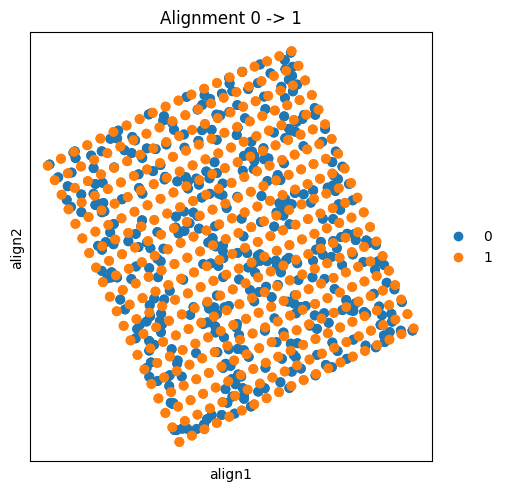

In [13]:
ap01.align(reference="1", key_added="align")
sq.pl.spatial_scatter(
    ap01.adata,
    shape=None,
    spatial_key="align",
    library_id="batch",
    color="batch",
    title="Alignment 0 -> 1",
)

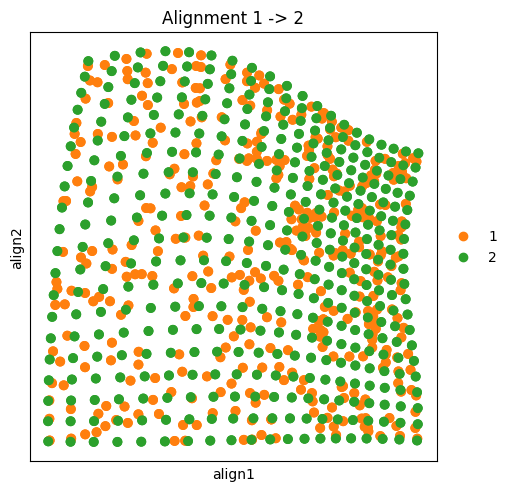

In [14]:
ap12.align(reference="2", key_added="align")
sq.pl.spatial_scatter(
    ap12.adata,
    shape=None,
    spatial_key="align",
    library_id="batch",
    color="batch",
    title="Alignment 1 -> 2",
)